In [7]:
import numpy as np
import pandas as pd

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import r2_score


# load ploting packages
import matplotlib.pyplot as plt
import seaborn as sns

# Model loading

In [4]:
# load features
# d1    Phe72 H𝜁 (Tyr72 H𝜂 ) – Glu166 O𝜀2
# d2    Lys73 H𝜁2 – Glu166 O𝜀2
# d3    Water H1 – Glu166 O𝜀2
# d4    Water H1 – Glu166 O𝜀1
# d5    Asn170 H𝛿2 – Glu166 O𝜀1
# d6    Water H2 – Asn170 O𝛿
# d7    Lys73 H𝜁1 – Water O
# d8    Lys73 H𝜁2 – Asn132 O𝛿
# d9    Water O – IPM C7
# d10  Lys73 H𝜁1 – Ser70 O𝛾
# d11  IPM 6𝛼OH – Water O
# d12 IPM 6𝛼OH – Asn132 O𝛿
# d13 IPM 6𝛼OH – Glu166 O𝜀1
# d14  IPM 6𝛼OH – Glu166 O𝜀2
# d15 Lys73 H𝜁1 – Ser130 O𝛾
# d16 Ser130 H𝛾 – IPM N4

features_name = ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11','d12', 'd13', 'd14', 'd15', 'd16']

wt_d1_16_distances = np.load("/users/chaoy/scratch/0.proj_kpc/2.data_anal/2.disanal/3.new_features_16_distances/kpc_wt_d1_16_features.npy")
wt_d2_16_distances = np.load("/users/chaoy/scratch/0.proj_kpc/2.data_anal/2.disanal/3.new_features_16_distances/kpc_wt_d2_16_features.npy")
y72_d1_16_distances = np.load("/users/chaoy/scratch/0.proj_kpc/2.data_anal/2.disanal/3.new_features_16_distances/kpc_y72_d1_16_features.npy")
y72_d2_16_distances = np.load("/users/chaoy/scratch/0.proj_kpc/2.data_anal/2.disanal/3.new_features_16_distances/kpc_y72_d2_16_features.npy")

# concatenate four systems together
features = np.concatenate((wt_d1_16_distances, wt_d2_16_distances, y72_d1_16_distances, y72_d2_16_distances), axis = 1).T

# build a dataframe for features
features_df = pd.DataFrame(features, columns = ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11','d12', 'd13', 'd14', 'd15', 'd16'])


# load energy
system_lables = ["wt_d1"] * 200 + ["wt_d2"] * 200 + ["y72_d1"] * 200 + ["y72_d2"] * 200

# load the barrier energy for every pathway
wt_d1_bar_ene = np.load("/users/chaoy/scratch/0.proj_kpc/1.sample/1.kpc_wt_d1/7.sp/0.b3lyp_d3/charge_ene/enes_all_paths.npz")['ene_barrier']
wt_d2_bar_ene = np.load("/users/chaoy/scratch/0.proj_kpc/1.sample/0.kpc_wt_d2/7.sp/0.b3lyp_d3/charge_ene/enes_all_paths.npz")['ene_barrier']
y72_d1_bar_ene = np.load("/users/chaoy/scratch/0.proj_kpc/1.sample/3.kpc_y72_d1/7.sp/0.b3lyp_d3/charge_ene/enes_all_paths.npz")['ene_barrier']
y72_d2_bar_ene = np.load("/users/chaoy/scratch/0.proj_kpc/1.sample/2.kpc_y72_d2/7.sp/0.b3lyp_d3/charge_ene/enes_all_paths.npz")['ene_barrier']

# merge barrier energy together
bar_ene = np.concatenate((wt_d1_bar_ene, wt_d2_bar_ene, y72_d1_bar_ene, y72_d2_bar_ene))

# Data Spliting

In [8]:
def split_dataset_and_scaled(X, y):
    # first split the dataset into training and testing set
    # scale X first

    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size= 0.1, random_state=42, stratify = system_lables)

    # return related dataset 
    return X_train, X_test,X_scaled, y_train, y_test

In [9]:
X_train, X_test,X_scaled, y_train, y_test = split_dataset_and_scaled(features_df, bar_ene)

# SVM Model Training

In [28]:
c_list = [0.001, 0.01, 0.1, 1, 10, 100]
epsilon_list = [0.01, 0.1, 1, 2,5, 10]
res = []
for C_p in c_list:
    res_tmp = []
    for ep_p in epsilon_list:
        regrsvm = SVR(C=C_p, epsilon=ep_p, kernel = 'rbf')
        regrsvm.fit(X_train,y_train)
        res_tmp.append(regrsvm.score(X_train,y_train))
    res.append(res_tmp)

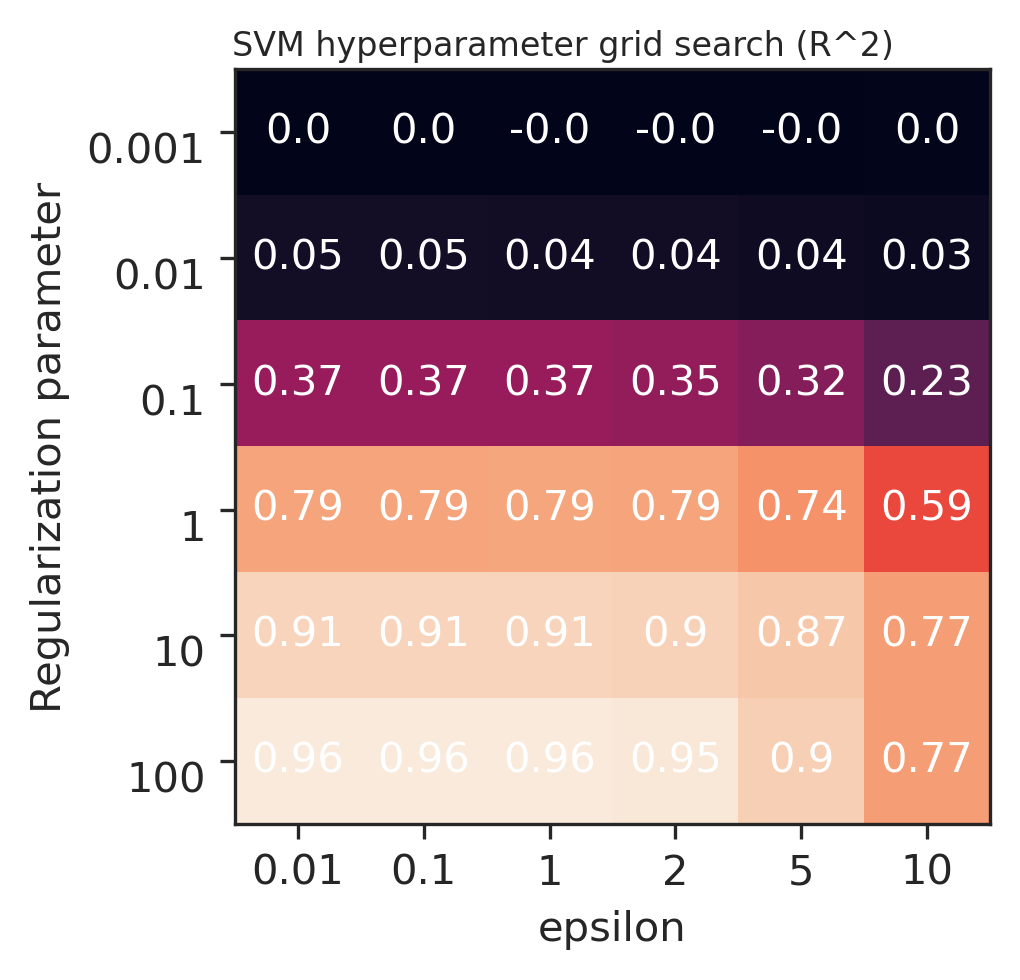

In [58]:
fig, ax = plt.subplots(figsize=(3.5, 3.5)  ,dpi=300, facecolor='w', edgecolor='k', )
plt.subplots_adjust(left=0.4/3.5, right=3.1/3.5, top=3.1/3.5, bottom=0.4/3.5)
im = ax.imshow(res)

ax.set_xticks(np.arange(0, len(res[0])))
ax.set_xticklabels(epsilon_list,  va='top', rotation=0, fontsize = 10) #rotation_mode="anchor",
ax.set_yticks(np.arange(0, len(res)))
ax.set_yticklabels(c_list,  va='top', rotation=0, rotation_mode="anchor", fontsize = 10)
ax.set_ylabel("Regularization parameter")
ax.set_xlabel("epsilon")

for i in range(len(res)):
    for j in range(len(res[0])):
        text = ax.text(j, i, np.around(res[i][j], decimals=2),
                       ha="center", va="center", color="w")
fig.suptitle(f"SVM hyperparameter grid search (R^2)", fontsize = 8,x = 0.55,y=0.92)

fig.tight_layout()
# plt.show()
# plt.savefig("./16_features_figures/coefficience_kpc_wt_ipm_d1.png",dpi=600, bbox_inches='tight')

# Get the optimal model

In [39]:
regrsvm_optimal = SVR(C=100, epsilon=0.1, kernel = 'rbf')
regrsvm_optimal.fit(X_train,y_train)

SVR(C=100)

In [62]:
def plot_the_pred_distribution_for_four_systems(model, bonds_new_df, bar_ene):
    # features for four systems 
    data_wt_d1 = bonds_new_df[0:200] 
    data_wt_d2 = bonds_new_df[200:400]
    data_y72_d1 = bonds_new_df[400:600]
    data_y72_d2 = bonds_new_df[600:800]
    
    # energy for four systems
    y_wt_d1 = bar_ene[0:200]
    y_wt_d2 = bar_ene[200:400]
    y_y72_d1 = bar_ene[400:600]
    y_y72_d2 = bar_ene[600:800]
    
    y_wt_d1_pred = model.predict(data_wt_d1).flatten()
    y_wt_d2_pred = model.predict(data_wt_d2).flatten()
    y_y72_d1_pred = model.predict(data_y72_d1).flatten()
    y_y72_d2_pred = model.predict(data_y72_d2).flatten()
    
    wt_d1_error = y_wt_d1_pred - y_wt_d1
    wt_d2_error = y_wt_d2_pred - y_wt_d2
    y72_d1_error = y_y72_d1_pred - y_y72_d1
    y72_d2_error = y_y72_d2_pred - y_y72_d2
#     print("MAX error in the training set:", max(train_error))
#     print("MIN error in the training set:", min(train_error))
#     print("MAE for the training set:", np.mean(np.abs(train_error)))
    
    rstr_r2 = r'$R^2$'
    rstr_mae = r'$MAE$'
    rstr_rmse = r'$RMSE$'
    rstr_nsamp = r'$n_{samples}$'


#   WT_D1
    r2_wt_d1 = round(r2_score(y_wt_d1, y_wt_d1_pred),4)
    mae_wt_d1 = np.mean(np.abs(y_wt_d1 - y_wt_d1_pred))
    rmse_wt_d1 = (np.sum((y_wt_d1 - y_wt_d1_pred)**2)/y_wt_d1.shape[0]) ** 0.5
#     n_train = y_train.shape[0]

#   WT_D2
    r2_wt_d2 = round(r2_score(y_wt_d2, y_wt_d2_pred),4)
    mae_wt_d2 = np.mean(np.abs(y_wt_d2 - y_wt_d2_pred))
    rmse_wt_d2 = (np.sum((y_wt_d2 - y_wt_d2_pred)**2)/y_wt_d2.shape[0]) ** 0.5
    
#   Y72_D1
    r2_y72_d1 = round(r2_score(y_y72_d1, y_y72_d1_pred),4)
    mae_y72_d1 = np.mean(np.abs(y_y72_d1 - y_y72_d1_pred))
    rmse_y72_d1 = (np.sum((y_y72_d1 - y_y72_d1_pred)**2)/y_y72_d1.shape[0]) ** 0.5
    
#   Y72_D2
    r2_y72_d2 = round(r2_score(y_y72_d2, y_y72_d2_pred),4)
    mae_y72_d2 = np.mean(np.abs(y_y72_d2 - y_y72_d2_pred))
    rmse_y72_d2 = (np.sum((y_y72_d2 - y_y72_d2_pred)**2)/y_y72_d2.shape[0]) ** 0.5



    # plot a figure for the predition and true value
    sns.set_style(style='white')
    sns.set_style("ticks")
    fig, axs = plt.subplots(2,2,figsize = (7,7), dpi =300, facecolor = 'w', edgecolor = 'k')

#   KPC-WT/IPM-D1
    plt.subplots_adjust(left=.3/7, right=6.7/7, top=6.9/7, bottom=.1/7, wspace = 0.3, hspace = 0.3)
    axs[0,0].tick_params(which='major', direction='in', length=6, width=1)
    axs[0,0].scatter(y_wt_d1, y_wt_d1_pred , color=sns.color_palette('colorblind')[0], zorder=2, s = 3)
    axs[0,0].axis([-5, 85, -5, 85])
    xpoints = ypoints = axs[0,0].set_xlim()
    axs[0,0].plot(xpoints, ypoints, linestyle='-', color='r', lw=1, scalex=False, scaley=False)
    axs[0,0].set_title(r'KPC-WT/IPM-$\Delta$1')
    axs[0,0].set_xlabel(r"$\Delta E_{QM/MM} (kcal$ $ mol^{-1})$")
    axs[0,0].set_ylabel(r"$\Delta E_{ML} (kcal$ $ mol^{-1})$")

    axs[0,0].xaxis.set_major_locator(plt.MultipleLocator(base=20.0))
    axs[0,0].yaxis.set_major_locator(plt.MultipleLocator(base=20.0))
    axs[0,0].text(0.94, 0.06, 
        f'{rstr_r2: >10} = {r2_wt_d1: <8.4f}\n{rstr_mae: >10} = {mae_wt_d1: <8.4f}\n{rstr_rmse: >10} = {rmse_wt_d1: <8.4f}\n {rstr_nsamp: >10} = {200: <8}', 
        ha='right', va='bottom', transform=axs[0,0].transAxes, fontsize=10)
    
    
#.  KPC-WT/IPM-D2
    axs[0,1].tick_params(which='major', direction='in', length=6, width=1)
    axs[0,1].scatter(y_wt_d2, y_wt_d2_pred , color=sns.color_palette('colorblind')[0], zorder=2, s = 3)
    axs[0,1].axis([-5, 85, -5, 85])
    xpoints = ypoints = axs[0,1].set_xlim()
    axs[0,1].plot(xpoints, ypoints, linestyle='-', color='r', lw=1, scalex=False, scaley=False)
    axs[0,1].set_title(r'KPC-WT/IPM-$\Delta$2')
    axs[0,1].set_xlabel(r"$\Delta E_{QM/MM} (kcal$ $ mol^{-1})$")
    axs[0,1].set_ylabel(r"$\Delta E_{ML} (kcal$ $ mol^{-1})$")

    axs[0,1].xaxis.set_major_locator(plt.MultipleLocator(base=20.0))
    axs[0,1].yaxis.set_major_locator(plt.MultipleLocator(base=20.0))
    axs[0,1].text(0.94, 0.06, 
        f'{rstr_r2: >10} = {r2_wt_d2: <8.4f}\n{rstr_mae: >10} = {mae_wt_d2: <8.4f}\n{rstr_rmse: >10} = {rmse_wt_d2: <8.4f}\n {rstr_nsamp: >10} = {200: <8}', 
        ha='right', va='bottom', transform=axs[0,1].transAxes, fontsize=10)
    

#   KPC-F72Y/IPM-D1
    axs[1,0].tick_params(which='major', direction='in', length=6, width=1)
    axs[1,0].scatter(y_y72_d1, y_y72_d1_pred , color=sns.color_palette('colorblind')[0], zorder=2, s = 3)
    axs[1,0].axis([-5, 85, -5, 85])
    xpoints = ypoints = axs[1,0].set_xlim()
    axs[1,0].plot(xpoints, ypoints, linestyle='-', color='r', lw=1, scalex=False, scaley=False)
    axs[1,0].set_title(r'KPC-F72Y/IPM-$\Delta$1')
    axs[1,0].set_xlabel(r"$\Delta E_{QM/MM} (kcal$ $ mol^{-1})$")
    axs[1,0].set_ylabel(r"$\Delta E_{ML} (kcal$ $ mol^{-1})$")

    axs[1,0].xaxis.set_major_locator(plt.MultipleLocator(base=20.0))
    axs[1,0].yaxis.set_major_locator(plt.MultipleLocator(base=20.0))
    axs[1,0].text(0.94, 0.06, 
        f'{rstr_r2: >10} = {r2_y72_d1: <8.4f}\n{rstr_mae: >10} = {mae_y72_d1: <8.4f}\n{rstr_rmse: >10} = {rmse_y72_d1: <8.4f}\n {rstr_nsamp: >10} = {200: <8}', 
        ha='right', va='bottom', transform=axs[1,0].transAxes, fontsize=10)
    

#   KPC-F72Y/IPM-D2
    axs[1,1].tick_params(which='major', direction='in', length=6, width=1)
    axs[1,1].scatter(y_y72_d2, y_y72_d2_pred , color=sns.color_palette('colorblind')[0], zorder=2, s = 3)
    axs[1,1].axis([-5, 85, -5, 85])
    xpoints = ypoints = axs[1,1].set_xlim()
    axs[1,1].plot(xpoints, ypoints, linestyle='-', color='r', lw=1, scalex=False, scaley=False)
    axs[1,1].set_title(r'KPC-F72Y/IPM-$\Delta$2')
    axs[1,1].set_xlabel(r"$\Delta E_{QM/MM} (kcal$ $ mol^{-1})$")
    axs[1,1].set_ylabel(r"$\Delta E_{ML} (kcal$ $ mol^{-1})$")

    axs[1,1].xaxis.set_major_locator(plt.MultipleLocator(base=20.0))
    axs[1,1].yaxis.set_major_locator(plt.MultipleLocator(base=20.0))
    axs[1,1].text(0.94, 0.06, 
        f'{rstr_r2: >10} = {r2_y72_d2: <8.4f}\n{rstr_mae: >10} = {mae_y72_d2: <8.4f}\n{rstr_rmse: >10} = {rmse_y72_d2: <8.4f}\n {rstr_nsamp: >10} = {200: <8}' , 
        ha='right', va='bottom', transform=axs[1,1].transAxes, fontsize=10)
    
#     fig.suptitle(f"SVM Model", fontsize = 12)
    plt.tight_layout()
    fig.savefig(f'./SI/2.SVM_four_systems_results.png')

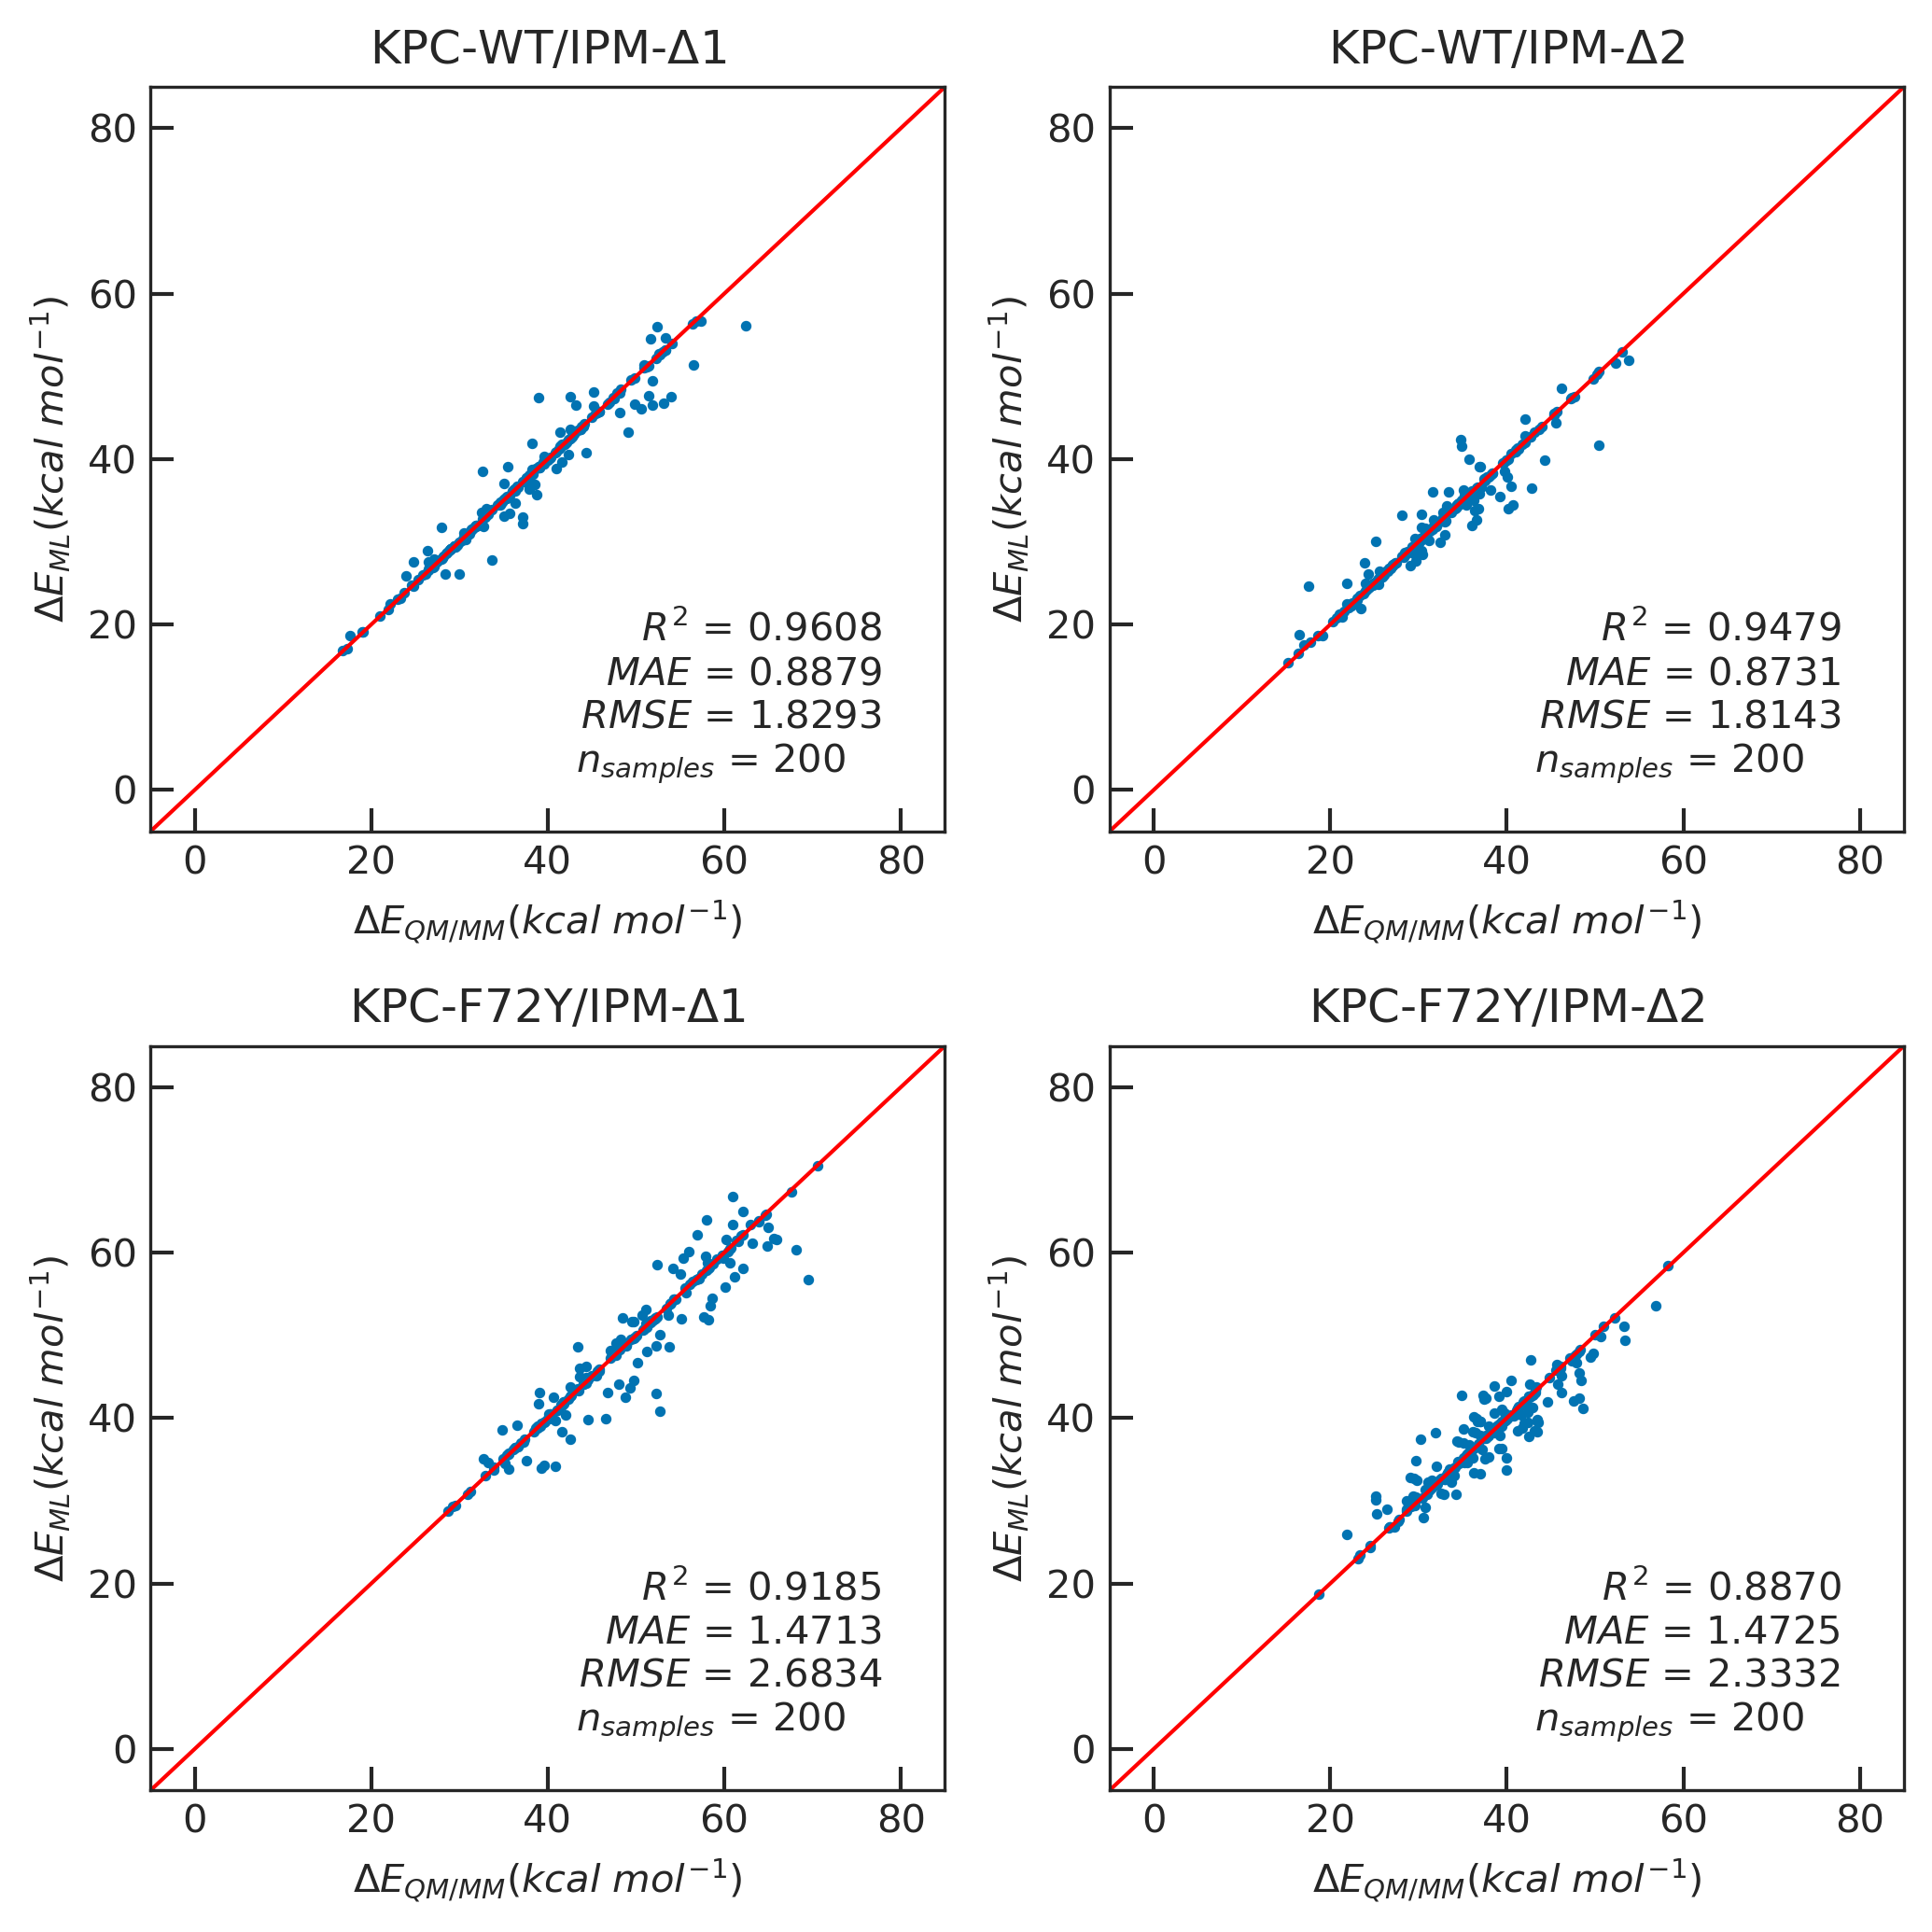

In [63]:
plot_the_pred_distribution_for_four_systems(regrsvm_optimal, X_scaled, bar_ene)

In [60]:
def plot_the_pred_distribution(model, X_train, X_test, y_train, y_test):
    # Training set
    y_train_pred = model.predict(X_train).flatten()
    y_test_pred = model.predict(X_test).flatten()
    train_error = y_train_pred - y_train
#     print("MAX error in the training set:", max(train_error))
#     print("MIN error in the training set:", min(train_error))
#     print("MAE for the training set:", np.mean(np.abs(train_error)))
    
    rstr_r2 = r'$R^2$'
    rstr_mae = r'$MAE$'
    rstr_rmse = r'$RMSE$'
    rstr_nsamp = r'$n_{samples}$'

    r2_train = round(r2_score(y_train, y_train_pred),4)
    mae_train = np.mean(np.abs(y_train - y_train_pred))
    rmse_train = (np.sum((y_train - y_train_pred)**2)/y_train.shape[0]) ** 0.5
    n_train = y_train.shape[0]
    
    r2_test = round(r2_score(y_test, y_test_pred),4)
    mae_test = np.mean(np.abs(y_test - y_test_pred))
    rmse_test = (np.sum((y_test - y_test_pred)**2)/y_test.shape[0]) ** 0.5
    n_test = y_test.shape[0]
    print(r2_train, mae_train, rmse_train, n_train)
    
    # Testing set
    y_test_pred = model.predict(X_test).flatten()
    test_error = y_test_pred - y_test
#     print("MAX error in the testing set:", max(test_error))
#     print("MIN error in the testing set:", min(test_error))
#     print("MAE for the testing set:", np.mean(np.abs(test_error)))
    r2_test = round(r2_score(y_test, y_test_pred),4)

    # plot a figure for the predition and true value
    sns.set_style(style='white')
    sns.set_style("ticks")
    fig, (ax1,ax2) = plt.subplots(1,2,figsize = (7,3.5), dpi =300, facecolor = 'w', edgecolor = 'k')
#     plt.setp(ax1.spines.values(), linewidth=2)
#     plt.subplot(121)
    plt.subplots_adjust(left=.3/7, right=6.7/7, top=3.4/3.5, bottom=.1/3.5,  wspace = 2/7)
    ax1.tick_params(which='major', direction='in', length=6, width=1)
    ax1.scatter(y_train, y_train_pred , color=sns.color_palette('colorblind')[0], zorder=2, s = 3)
    ax1.axis([-5, 85, -5, 85])
    xpoints = ypoints = ax1.set_xlim()
    ax1.plot(xpoints, ypoints, linestyle='-', color='r', lw=1, scalex=False, scaley=False)
    ax1.set_title('Training Set')
    ax1.set_xlabel(r"$\Delta E_{QM/MM} (kcal$ $ mol^{-1})$")
    ax1.set_ylabel(r"$\Delta E_{ML} (kcal$ $ mol^{-1})$")

    ax1.xaxis.set_major_locator(plt.MultipleLocator(base=20.0))
    ax1.yaxis.set_major_locator(plt.MultipleLocator(base=20.0))
#     ax1.text(0.06, 0.94, syslbl, ha='left', va='top', transform=ax.transAxes, fontsize=8)
    ax1.text(0.94, 0.06, 
        f'{rstr_r2: >10} = {r2_train: <8.4f}\n{rstr_mae: >10} = {mae_train: <8.4f}\n{rstr_rmse: >10} = {rmse_train: <8.4f}\n{rstr_nsamp: >10} = {n_train: <8}  ', 
        ha='right', va='bottom', transform=ax1.transAxes, fontsize=10)
    
    ax2.tick_params(which='major', direction='in', length=6, width=1)
    ax2.scatter(y_test, y_test_pred , color=sns.color_palette('colorblind')[0], zorder=2, s = 3)
    ax2.axis([-5, 85, -5, 85])
    xpoints = ypoints = ax2.set_xlim()
    ax2.plot(xpoints, ypoints, linestyle='-', color='r', lw=1, scalex=False, scaley=False)
    ax2.set_title('Validation Set')
    ax2.set_xlabel(r"$\Delta E_{QM/MM} (kcal$ $ mol^{-1})$")
    ax2.set_ylabel(r"$\Delta E_{ML} (kcal$ $ mol^{-1})$")

    ax2.xaxis.set_major_locator(plt.MultipleLocator(base=20.0))
    ax2.yaxis.set_major_locator(plt.MultipleLocator(base=20.0))
#     ax1.text(0.06, 0.94, syslbl, ha='left', va='top', transform=ax.transAxes, fontsize=8)
    ax2.text(0.94, 0.06, 
        f'{rstr_r2: >10} = {r2_test: <8.4f}\n{rstr_mae: >10} = {mae_test: <8.4f}\n{rstr_rmse: >10} = {rmse_test: <8.4f}\n{rstr_nsamp: >10} = {n_test: <8}  ', 
        ha='right', va='bottom', transform=ax2.transAxes, fontsize=12)
#     fig.suptitle(f"SVM Model", fontsize = 12)
    plt.tight_layout()
#     ax1.set_aspect(1.) 
    fig.savefig(f'./SI/2.SVM_training_and_validation_set_results.png')

0.9635 0.993853913460167 1.9763097166074248 720


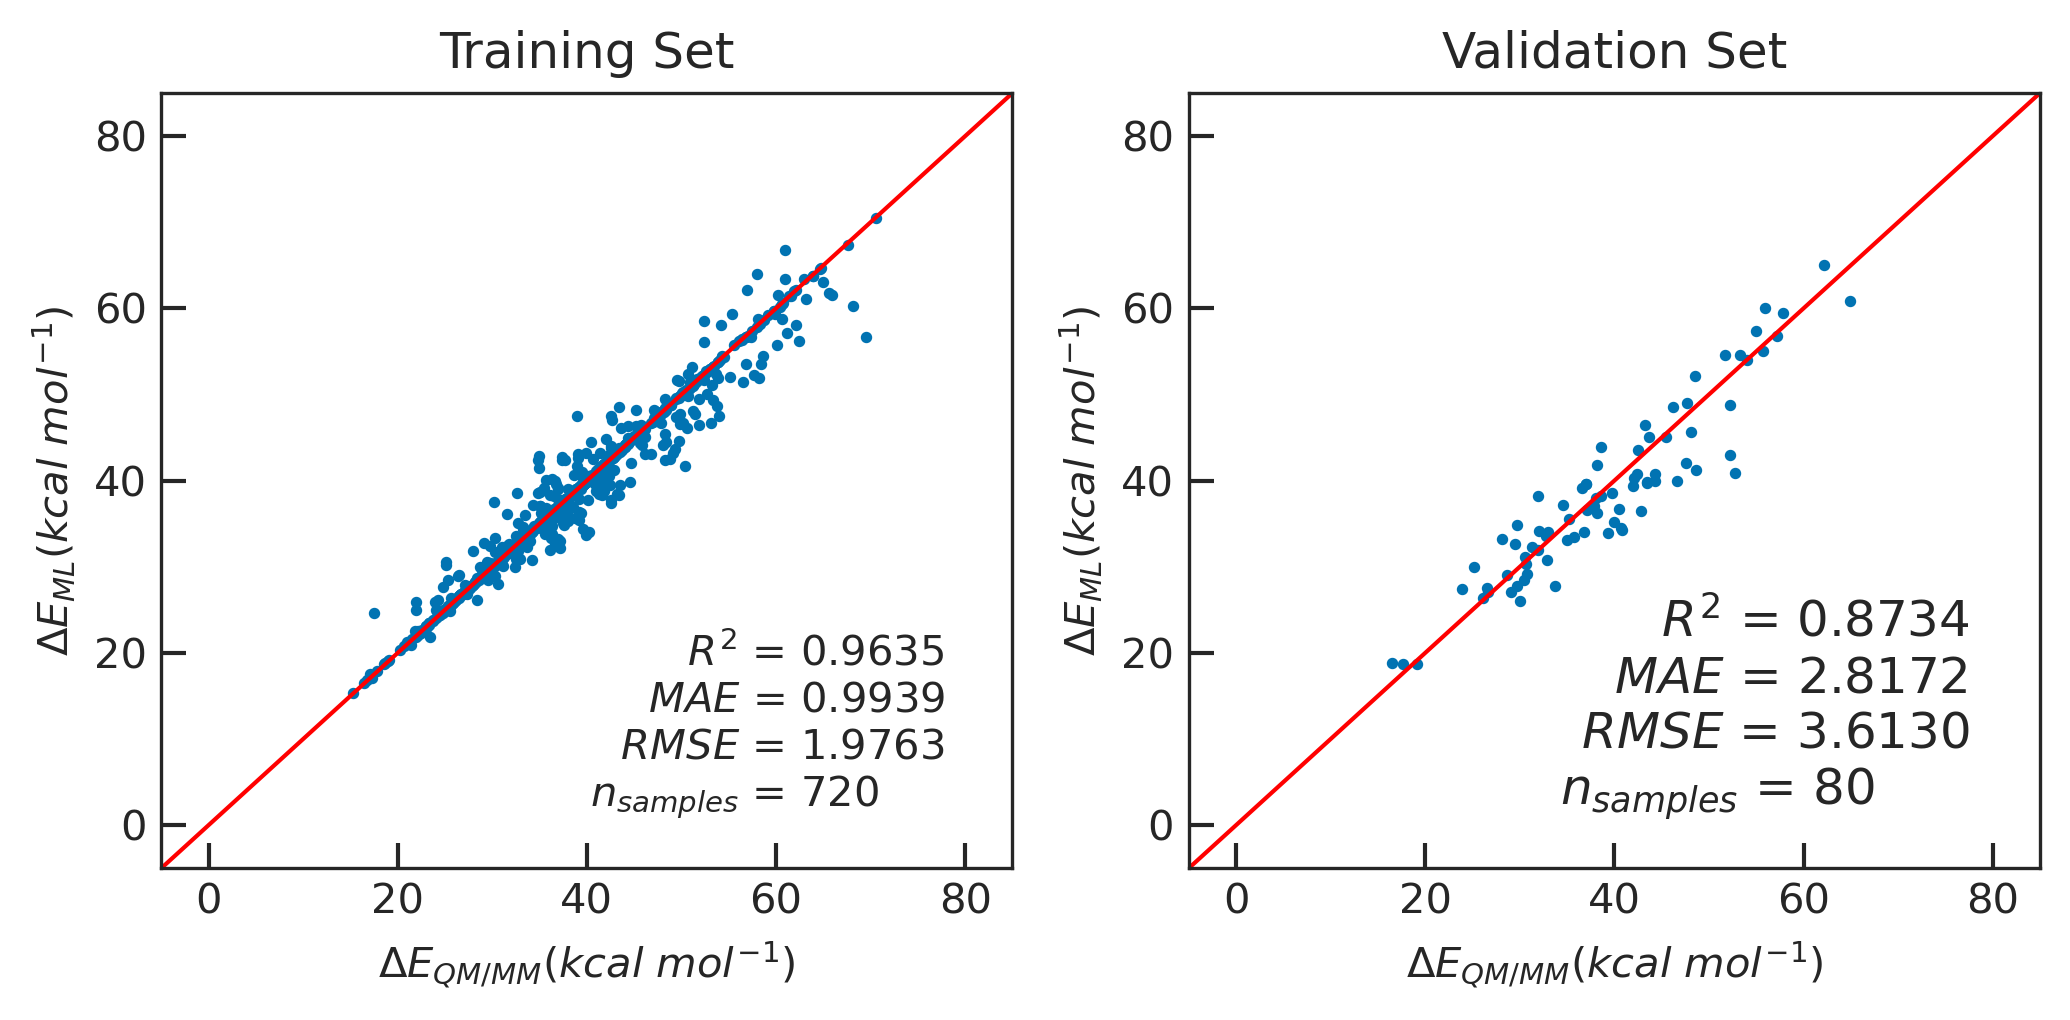

In [61]:
plot_the_pred_distribution(regrsvm_optimal, X_train, X_test, y_train, y_test)